## import libraries + read data

In [2]:
!pip install scikit-learn scipy plotly statsmodels scikeras seaborn pandas_profiling

In [98]:
!pip install tensorflow

In [3]:
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.losses import Huber, MeanAbsoluteError, MAPE, MAE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize
from scipy.stats import poisson
import pandas as pd
import json
import csv
from datetime import datetime
import requests
from bs4 import BeautifulSoup
import re
import ast
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import MaxPooling1D, Flatten, LSTM, Bidirectional, Dense, Dropout, Conv1D, SimpleRNN, GRU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import MeanAbsolutePercentageError, RootMeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.backend import set_epsilon
from tensorflow import keras
from scipy.integrate import odeint
from scipy.optimize import differential_evolution
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

from scipy import optimize
from scikeras.wrappers import KerasRegressor


In [4]:
cd ..

c:\Users\ADMIN\OneDrive - Hanoi University of Science and Technology\documents\at_school\20232\project\applied statistics


In [20]:
df = pd.read_csv("./data/hanoi_data.csv", parse_dates=['Date'], dayfirst=True)
# df = df[(df['Date'] >= '2021-1-1') & (df['Date'] <= '2021-9-1')]
df.head(5)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18060\3346617500.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("./data/hanoi_data.csv", parse_dates=['Date'], dayfirst=True)


,Date,daily_cases,retail_and_recreation,grocery_and_pharmacy,parks_change,transit_stations,workplaces,residential_change
0,2020-02-15,NaN,-8.0,-4.0,-5.0,-14.0,-4.0,7.0
1,2020-02-16,NaN,-15.0,-9.0,-11.0,-20.0,-5.0,8.0
2,2020-02-17,NaN,-16.0,-12.0,-10.0,-19.0,3.0,7.0
3,2020-02-18,NaN,-14.0,-9.0,-9.0,-18.0,10.0,8.0
4,2020-02-19,NaN,-8.0,-16.0,-15.0,-21.0,9.0,6.0


## EDA

In [6]:
df.isna().sum()


Date                       0
daily_cases              542
retail_and_recreation    545
grocery_and_pharmacy     545
parks_change             545
transit_stations         545
workplaces               906
residential_change       545
dtype: int64

In [5]:
df = df.dropna()


In [7]:
df.dtypes

Date                     datetime64[ns]
daily_cases                     float64
retail_and_recreation           float64
grocery_and_pharmacy            float64
parks_change                    float64
transit_stations                float64
workplaces                      float64
residential_change              float64
dtype: object

In [8]:
print(df['Date'].unique())

<DatetimeArray>
['2020-03-18 00:00:00', '2020-03-19 00:00:00', '2020-03-20 00:00:00',
 '2020-03-21 00:00:00', '2020-03-22 00:00:00', '2020-03-23 00:00:00',
 '2020-03-24 00:00:00', '2020-03-25 00:00:00', '2020-03-26 00:00:00',
 '2020-03-27 00:00:00',
 ...
 '2021-10-10 00:00:00', '2021-10-11 00:00:00', '2021-10-12 00:00:00',
 '2021-10-13 00:00:00', '2021-10-14 00:00:00', '2021-10-15 00:00:00',
 '2021-10-16 00:00:00', '2021-10-17 00:00:00', '2021-10-18 00:00:00',
 '2021-10-19 00:00:00']
Length: 581, dtype: datetime64[ns]


In [8]:
df.describe()

,Date,daily_cases,retail_and_recreation,grocery_and_pharmacy,parks_change,transit_stations,workplaces,residential_change
count,1519,977.000000,974.000000,974.000000,974.000000,974.000000,613.000000,974.000000
mean,2022-03-15 00:00:00,1672.724667,-25.291581,-9.950719,-22.379877,-30.336756,-8.026101,7.328542
min,2020-02-15 00:00:00,0.000000,-87.000000,-67.000000,-83.000000,-89.000000,-84.000000,-13.000000
25%,2021-02-28 12:00:00,0.000000,-35.750000,-17.000000,-33.000000,-52.000000,-17.000000,3.000000
50%,2022-03-15 00:00:00,4.000000,-19.500000,-5.000000,-19.000000,-24.000000,-2.000000,6.000000
75%,2023-03-29 12:00:00,239.000000,-9.000000,2.000000,-8.000000,-9.000000,10.000000,9.000000
max,2024-04-12 00:00:00,225694.000000,21.000000,22.000000,38.000000,56.000000,30.000000,43.000000
std,NaN,12218.727641,22.534277,18.894678,22.425197,26.621583,25.346797,8.966012


In [ ]:
from ydata_profiling import ProfileReport

# Generate the data profiling report 
report = ProfileReport(df, title='My Data')
report.to_file("report.html")

## Feature engineering

In [21]:
df['year']=df['Date'].dt.year 
df['month']=df['Date'].dt.month 
df['day']=df['Date'].dt.day
df.head(5)

,Date,daily_cases,retail_and_recreation,grocery_and_pharmacy,parks_change,transit_stations,workplaces,residential_change,year,month,day
0,2020-02-15,NaN,-8.0,-4.0,-5.0,-14.0,-4.0,7.0,2020,2,15
1,2020-02-16,NaN,-15.0,-9.0,-11.0,-20.0,-5.0,8.0,2020,2,16
2,2020-02-17,NaN,-16.0,-12.0,-10.0,-19.0,3.0,7.0,2020,2,17
3,2020-02-18,NaN,-14.0,-9.0,-9.0,-18.0,10.0,8.0,2020,2,18
4,2020-02-19,NaN,-8.0,-16.0,-15.0,-21.0,9.0,6.0,2020,2,19


In [22]:
df['lag_1'] = df['daily_cases'].shift(1)
df['lag_2'] = df['daily_cases'].shift(2)
df['lag_3'] = df['daily_cases'].shift(3)



In [23]:
# rolling window
df['rolling_window'] = df['daily_cases'].rolling(window=14).mean()


In [24]:
df['expanding_mean'] = df['daily_cases'].expanding(3).mean()


In [25]:
df = df.dropna()

In [26]:
#@title data preparation, sequence_length = 7, only normalize the training set
feature_columns = df.columns.difference(['Date'])
X_data = df[feature_columns].values
y_data = df['daily_cases'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=10/len(df), random_state=42, shuffle=False)

# Normalize the data using only the training data
scaler_X_train = StandardScaler()
scaler_y_train = StandardScaler()
scaler_X_test = StandardScaler()
scaler_y_test = StandardScaler()

X_train_scaled = scaler_X_train.fit_transform(X_train)
y_train_scaled = scaler_y_train.fit_transform(y_train.reshape(-1, 1))
X_test_scaled = scaler_X_test.fit_transform(X_test)
y_test_scaled = scaler_y_test.fit_transform(y_test.reshape(-1, 1))

def create_sequences(features, target, sequence_length):
    sequences = []
    labels = []
    for i in range(len(features) - sequence_length):
        sequence = features[i:i + sequence_length]
        label = target[i + sequence_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 3
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled.reshape(-1,1), sequence_length)

print(X_train_seq.shape, y_train_seq.shape, X_test_seq.shape, y_test_seq.shape)

(555, 3, 15) (555, 1) (7, 3, 15) (7, 1)


## Data Visualization

In [57]:
# import numpy as np
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

num_dates = len(df['Date'])
step = max(1, num_dates // 15)
display_dates = df['Date'][::step]

# Create subplots
fig = make_subplots(
    rows=2, cols=4,
    subplot_titles=("Original Training Data"),
    shared_xaxes=True, shared_yaxes=False
)

# Add training data traces
fig.add_trace(go.Scatter(x=df['Date'], y=df['daily_cases'], mode='lines', name='daily_cases'), row=1, col=1)
fig.add_trace(go.Scatter(x=df['Date'], y=df['retail_and_recreation'], mode='lines', name='retail_and_recreation', line=dict(color='red')), row=1, col=2)
fig.add_trace(go.Scatter(x=df['Date'], y=df['grocery_and_pharmacy'], mode='lines', name='grocery_and_pharmacy', line=dict(color='blue')), row=1, col=3)
fig.add_trace(go.Scatter(x=df['Date'], y=df['parks_change'], mode='lines', name='parks_change', line=dict(color='cyan')), row=1, col=4)
fig.add_trace(go.Scatter(x=df['Date'], y=df['transit_stations'], mode='lines', name='transit_stations', line=dict(color='yellow')), row=2, col=1)
fig.add_trace(go.Scatter(x=df['Date'], y=df['workplaces'], mode='lines', name='workplaces', line=dict(color='brown')), row=2, col=2)
fig.add_trace(go.Scatter(x=df['Date'], y=df['residential_change'], mode='lines', name='residential_change', line=dict(color='pink')), row=2, col=3)



# Update layout
fig.update_layout(
    height=600, width=800,
    title_text="COVID-19 Data",
    hovermode='x unified'
)

for i in range(1, 2):
    for j in range(1, 3):
        fig.update_xaxes(
            tickvals=display_dates,
            tickformat="%b %d\n%Y",
            tickangle=45,
            row=i, col=j
        )

# Show the plot
fig.show()


## Deep learning model

### LSTM

In [245]:
#@title model architecture

lstm_model = Sequential()
lstm_model.add(LSTM(400, dropout=0.2, return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
lstm_model.add(Dense(10, 'relu'))
lstm_model.add(Dense(1, 'linear'))
keras.backend.set_epsilon(1)
lstm_model.compile(optimizer=Adam(learning_rate=0.0001), loss=MeanAbsoluteError(), metrics=[MeanAbsolutePercentageError()])
lstm_model.summary()


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_171 (LSTM)                 │ (None, 400)            │       665,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 10)             │         4,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 669,621 (2.55 MB)

 Trainable params: 669,621 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [246]:
#@title training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.00000001)

history = lstm_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=8, validation_split=0.2, verbose=1)


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.5516 - mean_absolute_percentage_error: 45.1211 - val_loss: 0.8987 - val_mean_absolute_percentage_error: 61.6985
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3806 - mean_absolute_percentage_error: 29.6135 - val_loss: 0.8047 - val_mean_absolute_percentage_error: 54.1499
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3822 - mean_absolute_percentage_error: 24.2313 - val_loss: 0.7245 - val_mean_absolute_percentage_error: 47.7262
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3480 - mean_absolute_percentage_error: 23.0844 - val_loss: 0.5956 - val_mean_absolute_percentage_error: 37.7077
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3133 - mean_absolute_percentage_error: 21.4675 - val_loss: 0.5689 - val_mean_absolute_percentage_error: 35.8081
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2731 - mean_absolute_percentage_error: 22.3392 - val_loss: 0.5256 - val_me

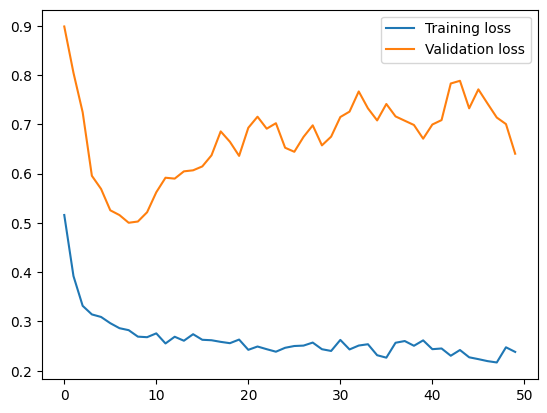

In [247]:
#@title plot the loss function
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [248]:
#@title visualization the result
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

y_pred_train = lstm_model.predict(X_train_seq).reshape(-1,1)
y_pred_test = lstm_model.predict(X_test_seq).reshape(-1,1)

num_dates = len(df['Date'])
step = max(1, num_dates // 15)
display_dates = df['Date'][::step]

# Create subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Original Training Data"),
    shared_xaxes=True
)

# Add training data traces
fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_train_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_pred_train.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=1)

# Add testing data traces
fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_test_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=2)
fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_pred_test.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=2)

# Update layout
fig.update_layout(
    height=400, width=600,
    title_text="COVID-19 Data",
    hovermode='x unified'
)

for i in range(1, 2):
    for j in range(1, 3):
        fig.update_xaxes(
            tickvals=display_dates,
            tickformat="%b %d\n%Y",
            tickangle=45,
            row=i, col=j
        )

# Show the plot
fig.show()



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [250]:
# Convert to tensors
y_true_tf = tf.convert_to_tensor(y_test_seq.reshape(-1), dtype=tf.float32)
y_pred_tf = tf.convert_to_tensor(y_pred_test.reshape(-1), dtype=tf.float32)

# Initialize the metrics
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mse_metric = tf.keras.metrics.MeanSquaredError()

# Update the state with the true and predicted values
mae_metric.update_state(y_true_tf, y_pred_tf)
mse_metric.update_state(y_true_tf, y_pred_tf)

# Calculate MAE and MSE
mae = mae_metric.result().numpy()
mse = mse_metric.result().numpy()

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R² score
total_error = tf.reduce_sum(tf.square(y_true_tf - tf.reduce_mean(y_true_tf)))
unexplained_error = tf.reduce_sum(tf.square(y_true_tf - y_pred_tf))
r2_score = 1 - tf.divide(unexplained_error, total_error).numpy()

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² score: {r2_score}")


MAE: 1.3439924716949463
RMSE: 1.4372049570083618
R² score: -0.8183324337005615


In [ ]:
lstm_model.save('./checkpoints/LSTM.h5')


### RNN

In [182]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(400, dropout=0.2, return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
rnn_model.add(Dense(10, activation='relu'))
rnn_model.add(Dense(1, activation='linear'))
set_epsilon(1)
rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=[MeanAbsolutePercentageError()])
rnn_model.summary()

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_5 (SimpleRNN)        │ (None, 400)            │       166,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 10)             │         4,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 170,421 (665.71 KB)

 Trainable params: 170,421 (665.71 KB)

 Non-trainable params: 0 (0.00 B)

In [183]:
#@title training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.00000001)

history = rnn_model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.7083 - mean_absolute_percentage_error: 58.0696 - val_loss: 0.9256 - val_mean_absolute_percentage_error: 62.6591
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8142 - mean_absolute_percentage_error: 62.0938 - val_loss: 0.8332 - val_mean_absolute_percentage_error: 56.8936
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6895 - mean_absolute_percentage_error: 55.6723 - val_loss: 0.8213 - val_mean_absolute_percentage_error: 56.6506
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6194 - mean_absolute_percentage_error: 46.6630 - val_loss: 0.8358 - val_mean_absolute_percentage_error: 56.9883
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6430 - mean_absolute_percentage_error: 48.7803 - val_loss: 0.8043 - val_mean_absolute_percentage_error: 52.7519
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6687 - mean_absolute_percentage_error: 51.3901 - val_loss: 0.7425 - val_mean_abs

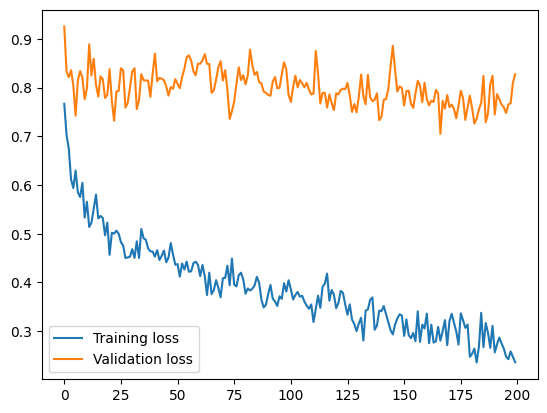

In [184]:
#@title plot the loss function
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [185]:
#@title visualization the result
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

y_pred_train = rnn_model.predict(X_train_seq).reshape(-1,1)
y_pred_test = rnn_model.predict(X_test_seq).reshape(-1,1)

num_dates = len(df['Date'])
step = max(1, num_dates // 15)
display_dates = df['Date'][::step]

# Create subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Original Training Data"),
    shared_xaxes=True
)

# Add training data traces
fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_train_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_pred_train.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=1)

# Add testing data traces
fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_test_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=2)
fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_pred_test.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=2)

# Update layout
fig.update_layout(
    height=400, width=600,
    title_text="COVID-19 Data",
    hovermode='x unified'
)

for i in range(1, 2):
    for j in range(1, 3):
        fig.update_xaxes(
            tickvals=display_dates,
            tickformat="%b %d\n%Y",
            tickangle=45,
            row=i, col=j
        )

# Show the plot
fig.show()



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [186]:
# Convert to tensors
y_true_tf = tf.convert_to_tensor(y_test_seq.reshape(-1), dtype=tf.float32)
y_pred_tf = tf.convert_to_tensor(y_pred_test.reshape(-1), dtype=tf.float32)

# Initialize the metrics
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mse_metric = tf.keras.metrics.MeanSquaredError()

# Update the state with the true and predicted values
mae_metric.update_state(y_true_tf, y_pred_tf)
mse_metric.update_state(y_true_tf, y_pred_tf)

# Calculate MAE and MSE
mae = mae_metric.result().numpy()
mse = mse_metric.result().numpy()

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R² score
total_error = tf.reduce_sum(tf.square(y_true_tf - tf.reduce_mean(y_true_tf)))
unexplained_error = tf.reduce_sum(tf.square(y_true_tf - y_pred_tf))
r2_score = 1 - tf.divide(unexplained_error, total_error).numpy()

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² score: {r2_score}")


MAE: 0.9804403185844421
RMSE: 1.4249156713485718
R² score: -0.5843085050582886


In [30]:
rnn_model.save("./checkpoints/rnn.h5")

### GRU

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 600)            │     1,110,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 8)              │         4,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,115,417 (4.25 MB)

 Trainable params: 1,115,417 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.6230 - mean_absolute_percentage_error: 51.7056 - val_loss: 0.7986 - val_mean_absolute_percentage_error: 52.1694
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.5564 - mean_absolute_percentage_error: 43.6631 - val_loss: 0.7875 - val_mean_absolute_percentage_error: 51.3804
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.5690 - mean_absolute_percentage_error: 42.2142 - val_loss: 0.7948 - val_mean_absolute_percentage_error: 49.6377
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.5963 - mean_absolute_percentage_error: 41.6549 - val_loss: 0.8207 - val_mean_absolute_percentage_error: 52.7971
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.5555 - mean_absolute_percentage_error: 40.3554 - val_loss: 0.8146 - val_mean_absolute_percentage_error: 51.5677
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.5450 - mean_absolute_percentage_error: 38.9768 - val_loss: 0.8129 - val_mean_abs

MAE: 0.8597689867019653
RMSE: 1.261847972869873
R² score: -0.2424401044845581


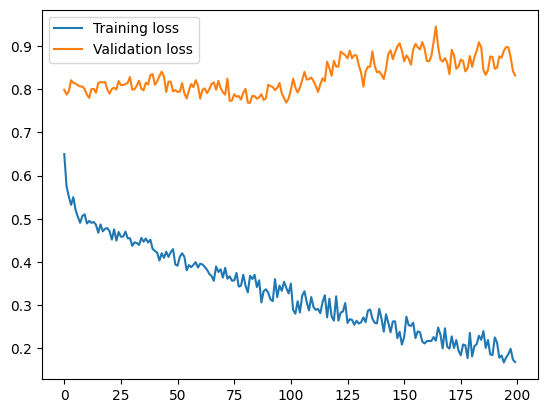

In [166]:
gru_model = Sequential()
gru_model.add(GRU(600, dropout=0.2, return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
gru_model.add(Dense(8, activation='relu'))
gru_model.add(Dense(1, activation='linear'))
set_epsilon(1)
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=[MeanAbsolutePercentageError()])
gru_model.summary()


# training
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.00000001)

history = gru_model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=32, validation_split=0.2, verbose=1)


# plot the loss function
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


# visualization the result
y_pred_train = gru_model.predict(X_train_seq).reshape(-1,1)
y_pred_test = gru_model.predict(X_test_seq).reshape(-1,1)

num_dates = len(df['Date'])
step = max(1, num_dates // 15)
display_dates = df['Date'][::step]

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Original Training Data"),
    shared_xaxes=True
)

fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_train_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_pred_train.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_test_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=2)
fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_pred_test.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=2)

fig.update_layout(
    height=400, width=600,
    title_text="COVID-19 Data",
    hovermode='x unified'
)

for i in range(1, 2):
    for j in range(1, 3):
        fig.update_xaxes(
            tickvals=display_dates,
            tickformat="%b %d\n%Y",
            tickangle=45,
            row=i, col=j
        )
fig.show()


# Compute score metrics
# Convert to tensors
y_true_tf = tf.convert_to_tensor(y_test_seq.reshape(-1), dtype=tf.float32)
y_pred_tf = tf.convert_to_tensor(y_pred_test.reshape(-1), dtype=tf.float32)

# Initialize the metrics
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mse_metric = tf.keras.metrics.MeanSquaredError()

# Update the state with the true and predicted values
mae_metric.update_state(y_true_tf, y_pred_tf)
mse_metric.update_state(y_true_tf, y_pred_tf)

# Calculate MAE and MSE
mae = mae_metric.result().numpy()
mse = mse_metric.result().numpy()

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R² score
total_error = tf.reduce_sum(tf.square(y_true_tf - tf.reduce_mean(y_true_tf)))
unexplained_error = tf.reduce_sum(tf.square(y_true_tf - y_pred_tf))
r2_score = 1 - tf.divide(unexplained_error, total_error).numpy()

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² score: {r2_score}")


# save the model
gru_model.save("./checkpoints/gru.h5")


### bidirectional LSTM

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 200)            │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 8)              │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,017 (343.82 KB)

 Trainable params: 88,017 (343.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.6908 - mean_absolute_percentage_error: 55.9927 - val_loss: 0.5580 - val_mean_absolute_percentage_error: 44.8193
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6350 - mean_absolute_percentage_error: 47.6693 - val_loss: 0.4566 - val_mean_absolute_percentage_error: 36.0338
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5490 - mean_absolute_percentage_error: 38.5562 - val_loss: 0.3224 - val_mean_absolute_percentage_error: 24.1646
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4247 - mean_absolute_percentage_error: 33.8517 - val_loss: 0.3033 - val_mean_absolute_percentage_error: 22.9354
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4413 - mean_absolute_percentage_error: 31.1017 - val_loss: 0.3481 - val_mean_absolute_percentage_error: 27.3129
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4139 - mean_absolute_percentage_error: 31.6709 - val_loss: 0.3997 - val_m

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


MAE: 0.8357642889022827
RMSE: 0.9913323521614075
R² score: -0.5151656866073608


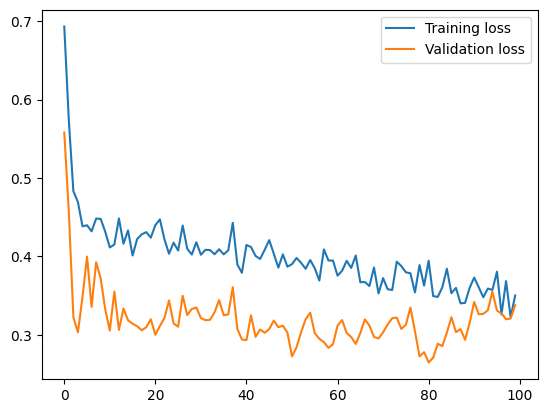

In [33]:
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(100, dropout=0.2, return_sequences=False), input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
bilstm_model.add(Dense(8, activation='relu'))
bilstm_model.add(Dense(1, activation='linear'))
K.set_epsilon(1)
bilstm_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=[MeanAbsolutePercentageError()])
bilstm_model.summary()


# training
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.00000001)

history = bilstm_model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=16, validation_split=0.2, verbose=1)


# plot the loss function
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


# visualization the result
y_pred_train = bilstm_model.predict(X_train_seq).reshape(-1,1)
y_pred_test = bilstm_model.predict(X_test_seq).reshape(-1,1)

num_dates = len(df['Date'])
step = max(1, num_dates // 15)
display_dates = df['Date'][::step]

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Original Training Data"),
    shared_xaxes=True
)

fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_train_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_pred_train.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_test_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=2)
fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_pred_test.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=2)

fig.update_layout(
    height=400, width=600,
    title_text="COVID-19 Data",
    hovermode='x unified'
)

for i in range(1, 2):
    for j in range(1, 3):
        fig.update_xaxes(
            tickvals=display_dates,
            tickformat="%b %d\n%Y",
            tickangle=45,
            row=i, col=j
        )
fig.show()


# Compute score metrics
# Convert to tensors
y_true_tf = tf.convert_to_tensor(y_test_seq.reshape(-1), dtype=tf.float32)
y_pred_tf = tf.convert_to_tensor(y_pred_test.reshape(-1), dtype=tf.float32)

# Initialize the metrics
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mse_metric = tf.keras.metrics.MeanSquaredError()

# Update the state with the true and predicted values
mae_metric.update_state(y_true_tf, y_pred_tf)
mse_metric.update_state(y_true_tf, y_pred_tf)

# Calculate MAE and MSE
mae = mae_metric.result().numpy()
mse = mse_metric.result().numpy()

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R² score
total_error = tf.reduce_sum(tf.square(y_true_tf - tf.reduce_mean(y_true_tf)))
unexplained_error = tf.reduce_sum(tf.square(y_true_tf - y_pred_tf))
r2_score = 1 - tf.divide(unexplained_error, total_error).numpy()

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² score: {r2_score}")


# save the model
bilstm_model.save("./checkpoints/bilstm.h5")


### stacked LSTM

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_45 (LSTM)                  │ (None, 3, 80)          │        30,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ (None, 3, 60)          │        33,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 3, 40)          │        16,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_48 (LSTM)                  │ (None, 20)             │         4,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 8)              │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,777 (335.07 KB)

 Trainable params: 85,777 (335.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.7079 - mean_absolute_percentage_error: 55.4164 - val_loss: 0.7820 - val_mean_absolute_percentage_error: 51.6714
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6582 - mean_absolute_percentage_error: 51.0936 - val_loss: 0.7585 - val_mean_absolute_percentage_error: 48.4408
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5893 - mean_absolute_percentage_error: 44.1885 - val_loss: 0.8362 - val_mean_absolute_percentage_error: 54.1989
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4476 - mean_absolute_percentage_error: 34.1822 - val_loss: 0.7765 - val_mean_absolute_percentage_error: 47.7120
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4972 - mean_absolute_percentage_error: 34.7610 - val_loss: 0.7920 - val_mean_absolute_percentage_error: 48.8712
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4488 - mean_absolute_percentage_error: 31.2910 - val_loss: 0.7852 - val_

MAE: 0.5304998755455017
RMSE: 0.7919836640357971
R² score: 0.510566383600235


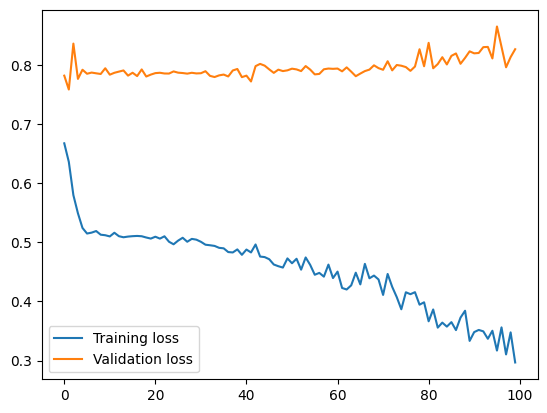

In [163]:
stacked_lstm_model = Sequential()
stacked_lstm_model.add(LSTM(80, dropout=0.1, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
stacked_lstm_model.add(LSTM(60, dropout=0.1, return_sequences=True))  
stacked_lstm_model.add(LSTM(40, dropout=0.1, return_sequences=True)) 
stacked_lstm_model.add(LSTM(20, dropout=0.1, return_sequences=False)) 
stacked_lstm_model.add(Dense(8, activation='relu'))
stacked_lstm_model.add(Dense(1, activation='linear'))
set_epsilon(1)
stacked_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=[MeanAbsolutePercentageError()])
stacked_lstm_model.summary()


# training
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.00000001)

history = stacked_lstm_model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=16, validation_split=0.2, verbose=1)


# plot the loss function
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


# visualization the result
y_pred_train = stacked_lstm_model.predict(X_train_seq).reshape(-1,1)
y_pred_test = stacked_lstm_model.predict(X_test_seq).reshape(-1,1)

num_dates = len(df['Date'])
step = max(1, num_dates // 15)
display_dates = df['Date'][::step]

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Original Training Data"),
    shared_xaxes=True
)

fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_train_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_pred_train.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_test_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=2)
fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_pred_test.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=2)

fig.update_layout(
    height=400, width=600,
    title_text="COVID-19 Data",
    hovermode='x unified'
)

for i in range(1, 2):
    for j in range(1, 3):
        fig.update_xaxes(
            tickvals=display_dates,
            tickformat="%b %d\n%Y",
            tickangle=45,
            row=i, col=j
        )
fig.show()


# Compute score metrics
# Convert to tensors
y_true_tf = tf.convert_to_tensor(y_test_seq.reshape(-1), dtype=tf.float32)
y_pred_tf = tf.convert_to_tensor(y_pred_test.reshape(-1), dtype=tf.float32)

# Initialize the metrics
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mse_metric = tf.keras.metrics.MeanSquaredError()

# Update the state with the true and predicted values
mae_metric.update_state(y_true_tf, y_pred_tf)
mse_metric.update_state(y_true_tf, y_pred_tf)

# Calculate MAE and MSE
mae = mae_metric.result().numpy()
mse = mse_metric.result().numpy()

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R² score
total_error = tf.reduce_sum(tf.square(y_true_tf - tf.reduce_mean(y_true_tf)))
unexplained_error = tf.reduce_sum(tf.square(y_true_tf - y_pred_tf))
r2_score = 1 - tf.divide(unexplained_error, total_error).numpy()

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² score: {r2_score}")


# save the model
# stacked_lstm_model.save("./checkpoints/stacked_lstm.h5")


### Convolutional LSTM

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_84 (Conv1D)              │ (None, 2, 32)          │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_76 (MaxPooling1D) │ (None, 2, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_164 (LSTM)                 │ (None, 2, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_165 (LSTM)                 │ (None, 2, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_166 (LSTM)                 │ (None, 2, 16)          │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_167 (LSTM)                 │ (None, 2, 8)           │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 2, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_35 (Flatten)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,193 (164.82 KB)

 Trainable params: 42,193 (164.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
11/11 - 7s - 654ms/step - loss: 0.6361 - mean_absolute_percentage_error: 51.9230 - val_loss: 0.9758 - val_mean_absolute_percentage_error: 67.7511
Epoch 2/200
11/11 - 0s - 14ms/step - loss: 0.6331 - mean_absolute_percentage_error: 51.6119 - val_loss: 0.9769 - val_mean_absolute_percentage_error: 67.8358
Epoch 3/200
11/11 - 0s - 14ms/step - loss: 0.6302 - mean_absolute_percentage_error: 51.3215 - val_loss: 0.9783 - val_mean_absolute_percentage_error: 67.9420
Epoch 4/200
11/11 - 0s - 13ms/step - loss: 0.6267 - mean_absolute_percentage_error: 50.9557 - val_loss: 0.9794 - val_mean_absolute_percentage_error: 68.0263
Epoch 5/200
11/11 - 0s - 12ms/step - loss: 0.6235 - mean_absolute_percentage_error: 50.6291 - val_loss: 0.9804 - val_mean_absolute_percentage_error: 68.1030
Epoch 6/200
11/11 - 0s - 12ms/step - loss: 0.6199 - mean_absolute_percentage_error: 50.2649 - val_loss: 0.9811 - val_mean_absolute_percentage_error: 68.1626
Epoch 7/200
11/11 - 0s - 13ms/step - loss: 0.6158 - mean_

MAE: 1.5607572793960571
RMSE: 1.704502820968628
R² score: -1.5575921535491943


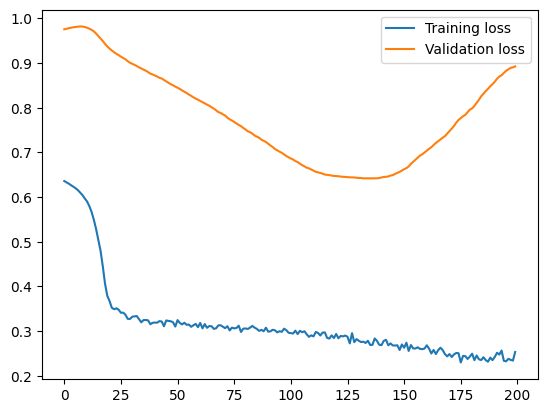

In [230]:
conv_lstm_model = Sequential()
conv_lstm_model.add(Conv1D(32, 2, activation='relu', input_shape=(3, 15)))  # Use kernel size 2 to fit the small input
conv_lstm_model.add(MaxPooling1D(pool_size=1))  # Pooling size 1 to prevent negative dimensions
conv_lstm_model.add(LSTM(64, return_sequences=True))
conv_lstm_model.add(LSTM(32, return_sequences=True))
conv_lstm_model.add(LSTM(16, return_sequences=True))
conv_lstm_model.add(LSTM(8, return_sequences=True))
conv_lstm_model.add(Dropout(0.2))
conv_lstm_model.add(Conv1D(16, 2, activation='relu'))  # Adjust kernel size to fit the reduced dimensions
conv_lstm_model.add(MaxPooling1D(pool_size=1))  # Pooling size 1 to prevent negative dimensions
conv_lstm_model.add(Flatten())
conv_lstm_model.add(Dense(units=1))
set_epsilon(1)
conv_lstm_model.compile(optimizer=Adam(learning_rate=0.0001), loss=MeanAbsoluteError(), metrics=[MeanAbsolutePercentageError()])

conv_lstm_model.summary()


# training
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.00000001)

history = conv_lstm_model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=16, validation_split=0.2, verbose=2)


# plot the loss function
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


# visualization the result
y_pred_train = conv_lstm_model.predict(X_train_seq).reshape(-1,1)
y_pred_test = conv_lstm_model.predict(X_test_seq).reshape(-1,1)

num_dates = len(df['Date'])
step = max(1, num_dates // 15)
display_dates = df['Date'][::step]

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Original Training Data"),
    shared_xaxes=True
)

fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_train_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_pred_train.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_test_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=2)
fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_pred_test.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=2)

fig.update_layout(
    height=400, width=600,
    title_text="COVID-19 Data",
    hovermode='x unified'
)

for i in range(1, 2):
    for j in range(1, 3):
        fig.update_xaxes(
            tickvals=display_dates,
            tickformat="%b %d\n%Y",
            tickangle=45,
            row=i, col=j
        )
fig.show()


# Compute score metrics
# Convert to tensors
y_true_tf = tf.convert_to_tensor(y_test_seq.reshape(-1), dtype=tf.float32)
y_pred_tf = tf.convert_to_tensor(y_pred_test.reshape(-1), dtype=tf.float32)

# Initialize the metrics
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mse_metric = tf.keras.metrics.MeanSquaredError()

# Update the state with the true and predicted values
mae_metric.update_state(y_true_tf, y_pred_tf)
mse_metric.update_state(y_true_tf, y_pred_tf)

# Calculate MAE and MSE
mae = mae_metric.result().numpy()
mse = mse_metric.result().numpy()

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R² score
total_error = tf.reduce_sum(tf.square(y_true_tf - tf.reduce_mean(y_true_tf)))
unexplained_error = tf.reduce_sum(tf.square(y_true_tf - y_pred_tf))
r2_score = 1 - tf.divide(unexplained_error, total_error).numpy()

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² score: {r2_score}")


# save the model
conv_lstm_model.save("./checkpoints/conv_lstm.h5")


In [102]:
!pip uninstall tensorflow
!pip install tensorflow==2.12.0

^C


ERROR: Could not find a version that satisfies the requirement tensorflow==2.12.0 (from versions: 2.16.0rc0, 2.16.1, 2.17.0rc0)
ERROR: No matching distribution found for tensorflow==2.12.0


### hyperparameter tuning

In [130]:
# Define a function to create the Keras model
def create_model(hidden_units=8, optimizer='adam', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(hidden_units, dropout=0.2, return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss=MeanAbsoluteError(), metrics=[MeanAbsolutePercentageError()])
    return model

# Wrap the Keras model using KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the parameter grid
batch_size = [8, 16, 32]
epochs = [200, 300, 500]
optimizers = ['adam', 'sgd', 'rmsprop']  # Added optimizers
param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizers)

# Perform Grid Search with appropriate scoring for regression
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='neg_mean_absolute_error', error_score='raise')

# Check shapes and data types (assuming X_train_seq and y_train_seq are defined somewhere)
print(X_train_seq.shape)
print(y_train_seq.shape)
print(X_train_seq.dtype if hasattr(X_train_seq, 'dtype') else "Not a DataFrame")
print(y_train_seq.dtype if hasattr(y_train_seq, 'dtype') else "Not a Series")

# Try a single fit to see if it works
try:
    single_model = create_model()
    single_model.fit(X_train_seq, y_train_seq, epochs=1, batch_size=8)
    print("Single fit successful")
except ValueError as e:
    print(f"Single fit ValueError: {e}")

# Fit the grid search
try:
    grid_result = grid.fit(X_train_seq, y_train_seq)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
except ValueError as e:
    print(f"GridSearchCV ValueError: {e}")


(544, 14, 15)
(544, 1)
float64
float64


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4918 - mean_absolute_percentage_error: 33.9928
Single fit successful


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best: -0.396948 using {'batch_size': 32, 'epochs': 200, 'optimizer': 'sgd'}


In [129]:
param_names = list(model._get_param_names())

# Print out the parameter names
print("Allowed parameters:")
for param in param_names:
    print(param)

Allowed parameters:
model
build_fn
warm_start
random_state
optimizer
loss
metrics
batch_size
validation_batch_size
verbose
callbacks
validation_split
shuffle
run_eagerly
epochs


## SIR model

In [26]:
df1 = df[(df['Date'] >= '2021-3-1') & (df['Date'] <= '2021-4-1')]
df2 = df[(df['Date'] >= '2021-5-1') & (df['Date'] <= '2021-6-1')]


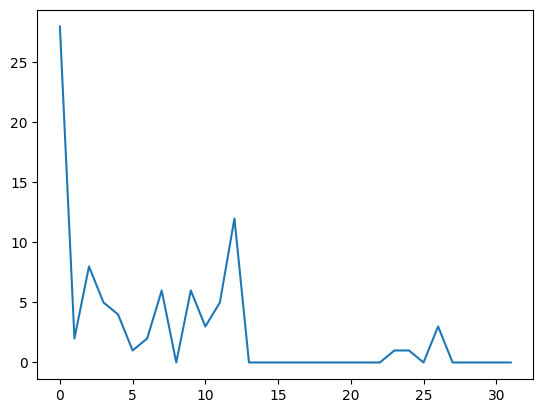

In [86]:
plt.plot(np.arange(len(df2)), df2['daily_cases'].values)

(100, 1) (100,)
Estimated beta: 0.8298759061258633
Estimated gamma: 0.009957377524559028
Estimated c_s: 1e-08
Estimated c_i: 1e-08


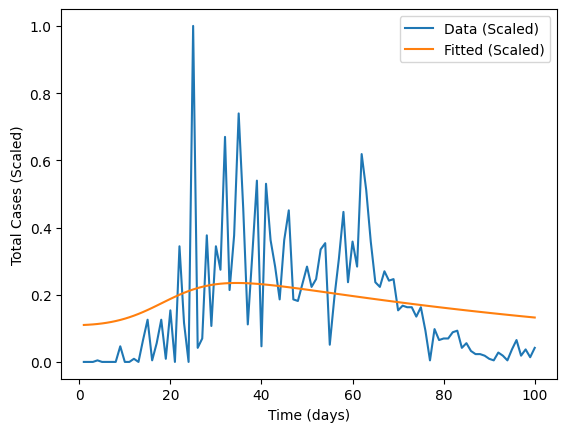

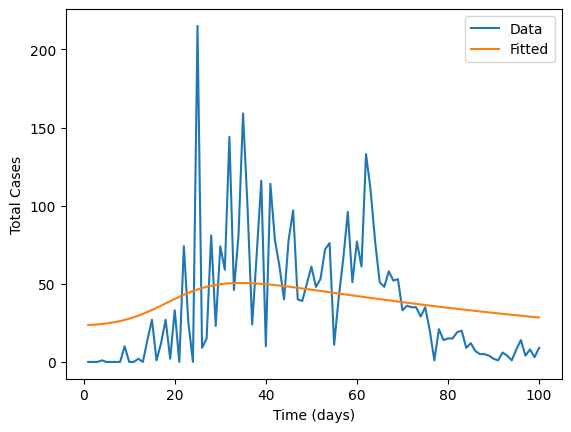

In [35]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with a 'daily_cases' column
# df = pd.read_csv("your_data.csv")  # Uncomment and load your data accordingly

# Prepare data
y_total = df["daily_cases"].iloc[425:525].values.reshape(-1, 1)
x_total = np.arange(1, len(y_total) + 1)
print(y_total.shape, x_total.shape)

# Scale data
scaler = MinMaxScaler()
scaler.fit(y_total)
y_scaled = scaler.transform(y_total).flatten()  # Ensure y_scaled is 1D

# Model function
def vaccine_model(state, t, beta, gamma, c_s, c_i):
    S, I, R, V, Iv = state
    lambda_ = beta * I / N + c_i * beta * Iv / N
    dS = -lambda_ * S
    dI = lambda_ * S - gamma * I
    dR = gamma * I + gamma * Iv
    dV = -c_s * lambda_ * V
    dIv = c_s * lambda_ * V - gamma * Iv
    return [dS, dI, dR, dV, dIv]

# Function to integrate the model
def integrate_model(state, t, beta, gamma, c_s, c_i):
    return odeint(vaccine_model, state, t, args=(beta, gamma, c_s, c_i))

# Initial number of people in each compartment
N = 1  # Total population
p = 0.6  # Vaccination coverage
initial_state_values = [0.2,  # Susceptible (unvaccinated)
                        1/100,       # Infected
                        0.2,            # Recovered
                        0.1,        # Vaccinated
                        0.1]            # Infected (vaccinated)

# Function to calculate the mean squared error (MSE)
def mse(params, y_data):
    t = x_total
    solution = integrate_model(initial_state_values, t, *params)
    predicted_infected = solution[:, 1] + solution[:, 4]  # Sum of I and Iv compartments
    squared_errors = (y_data - predicted_infected) ** 2
    return np.mean(squared_errors)  # Calculate mean squared error

# Define bounds for parameters
bounds = [(0.001, 100),  # beta
          (0.00000001, 100),  # gamma
          (0.00000001, 0.9),  # c_s
          (0.00000001, 0.9)]  # c_i

# Initial guesses for parameters
initial_guess = [0.001, 0.001, 0.001, 0.001]

# Optimize using L-BFGS-B
result = minimize(mse, initial_guess, args=(y_scaled,), method='L-BFGS-B', bounds=bounds)

# Extract fitted parameters
beta_fit, gamma_fit, c_s_fit, c_i_fit = result.x

# Solve the model with the fitted parameters
fitted_solution = integrate_model(initial_state_values, x_total, beta_fit, gamma_fit, c_s_fit, c_i_fit)

# Optionally, you can rescale the fitted values back to the original scale
fitted_infected_rescaled = scaler.inverse_transform((fitted_solution[:, 1] + fitted_solution[:, 4]).reshape(-1, 1)).flatten()

# Plot the results
print("Estimated beta:", beta_fit)
print("Estimated gamma:", gamma_fit)
print("Estimated c_s:", c_s_fit)
print("Estimated c_i:", c_i_fit)

plt.plot(x_total, y_scaled, label="Data (Scaled)")
plt.plot(x_total, fitted_solution[:, 1] + fitted_solution[:, 4], '-', label="Fitted (Scaled)")
plt.xlabel("Time (days)")
plt.ylabel("Total Cases (Scaled)")
plt.legend()
plt.show()

# If you want to plot the rescaled fitted data
plt.plot(x_total, y_total.flatten(), label="Data")
plt.plot(x_total, fitted_infected_rescaled, '-', label="Fitted")
plt.xlabel("Time (days)")
plt.ylabel("Total Cases")
plt.legend()
plt.show()


## ARIMA model

In [89]:
# Fit the ARIMA model
model = ARIMA(df['daily_cases'], order=(5, 1, 5))
model_fit = model.fit()

# Print the model summary
(model_fit.summary())


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization fail

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            daily_cases   No. Observations:                  581
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -2453.221
Date:                Sun, 16 Jun 2024   AIC                           4928.442
Time:                        16:00:50   BIC                           4976.435
Sample:                             0   HQIC                          4947.153
                                - 581                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8897      0.146     12.941      0.000       1.603       2.176
ar.L2         -1.4292      0.290     -4.935      0.000      -1.997      -0.862
ar.L3          0.4927      0.256      1.924      0.054      -0.009       0.995
ar.L4         -0.2998      0.107     -2.814      0.005      -0.509      -0.091
ar.L5          0.2460      0.043      5.673      0.000       0.161       0.331
ma.L1         -2.8801      0.146    -19.736      0.000      -3.166      -2.594
ma.L2          3.4676      0.438      7.916      0.000       2.609       4.326
ma.L3         -1.9438      0.574     -3.387      0.001      -3.069      -0.819
ma.L4          0.3408      0.376      0.907      0.364      -0.395       1.077
ma.L5          0.0723      0.108      0.667      0.504      -0.140       0.284
sigma2       280.9632      5.212     53.906      0.000     270.748     291.179
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             34478.74
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               9.32   Skew:                             3.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Determine the value of d

In [25]:
def test_stationarity(timeseries):
    # Perform Augmented Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='BIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    return dftest[1]

# Function to determine d using logarithm
def determine_d(timeseries):    
    p_value = test_stationarity(timeseries)
    d = 0
    while p_value > 0.05:  # Adjust significance level as needed
        timeseries_log_diff = timeseries.diff().dropna()
        p_value = test_stationarity(timeseries_log_diff)
        d += 1
    return d


# Determine optimal d for daily_cases using logarithm
optimal_d = determine_d(df['daily_cases'])
print(f'Optimal d for daily_cases: {optimal_d}')


Results of Dickey-Fuller Test:
Test Statistic                   1.846264
p-value                          0.998436
#Lags Used                       3.000000
Number of Observations Used    577.000000
Critical Value (1%)             -3.441734
Critical Value (5%)             -2.866562
Critical Value (10%)            -2.569445
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                 -25.400896
p-value                          0.000000
#Lags Used                       2.000000
Number of Observations Used    577.000000
Critical Value (1%)             -3.441734
Critical Value (5%)             -2.866562
Critical Value (10%)            -2.569445
dtype: float64
Optimal d for daily_cases: 1


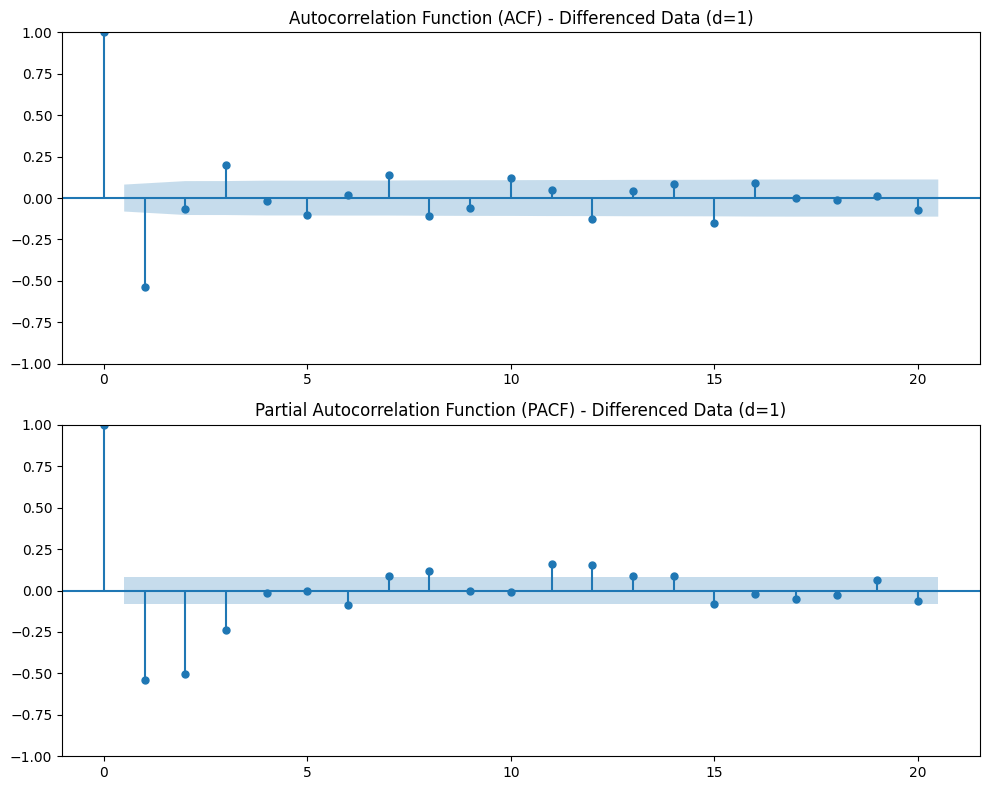

In [27]:
%matplotlib inline
# Plot ACF and PACF
df['daily_cases_diff'] = df['daily_cases'].diff(optimal_d)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(df['daily_cases_diff'].dropna(), lags=20, ax=ax1)
ax1.set_title(f'Autocorrelation Function (ACF) - Differenced Data (d={optimal_d})')

plot_pacf(df['daily_cases_diff'].dropna(), lags=20, ax=ax2)
ax2.set_title(f'Partial Autocorrelation Function (PACF) - Differenced Data (d={optimal_d})')

plt.tight_layout()
plt.show()


In [32]:
model_arima = ARIMA(df['daily_cases_diff'].values, order = (2, 1, 4))
model_fit = model_arima.fit()
print(model_fit.summary())

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  581
Model:                 ARIMA(2, 1, 4)   Log Likelihood               -2461.020
Date:                Sun, 16 Jun 2024   AIC                           4936.041
Time:                        22:20:27   BIC                           4966.582
Sample:                             0   HQIC                          4947.948
                                - 581                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4067      0.031    -13.059      0.000      -0.468      -0.346
ar.L2         -0.8444      0.022    -37.819      0.000      -0.888      -0.801
ma.L1         -1.5033      0.037    -40.310      0.0

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Training RMSE: 10.87388352735016
Testing RMSE: 48.14126160112707


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


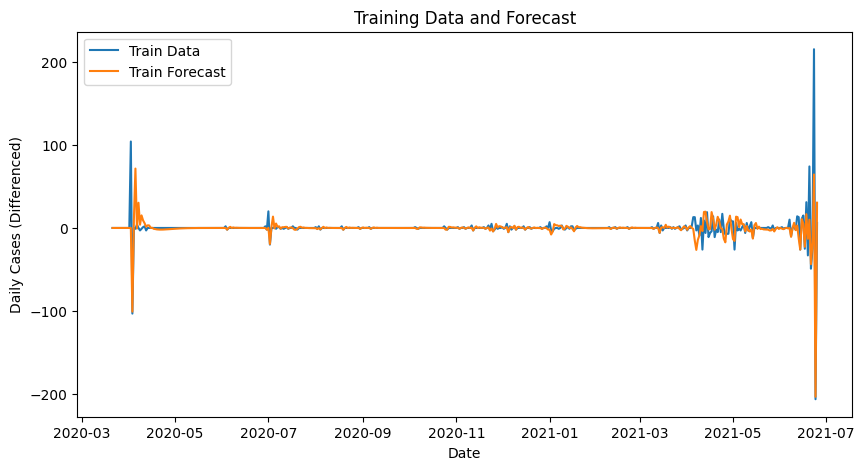

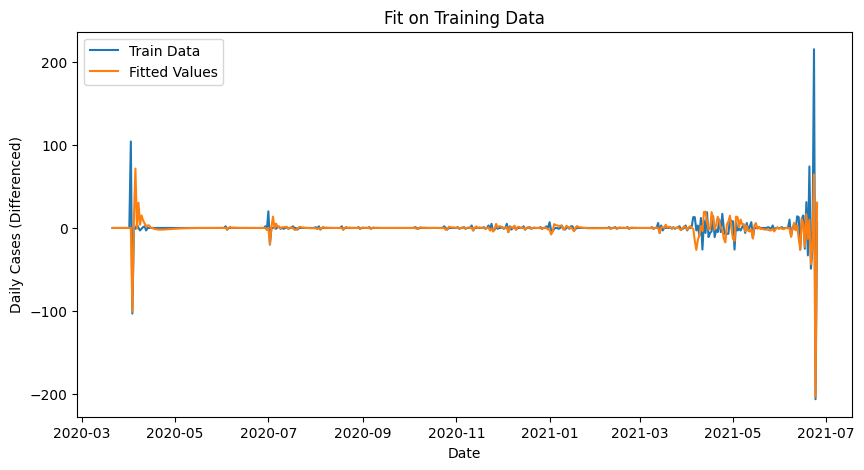

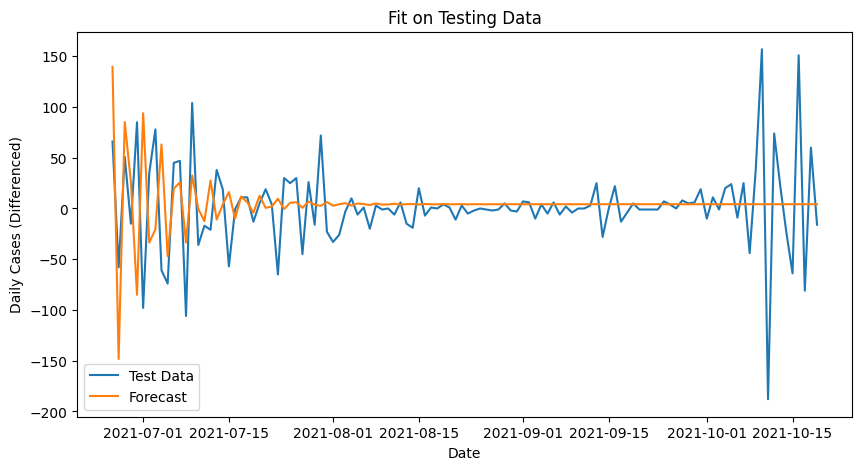

In [39]:
# Create differenced series
df['daily_cases_diff'] = df['daily_cases'].diff(d)

# Drop NaN values resulting from differencing
df.dropna(inplace=True)

# Split data into training and testing sets (80% training, 20% testing)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Fit ARIMA model on training data
model = ARIMA(train['daily_cases_diff'], order=(p, d, q))
fitted_model = model.fit()

# Forecast on training data
train_forecast = fitted_model.fittedvalues

# Ensure the train_forecast index matches the train index
train_forecast = train_forecast[:len(train)]

# Forecast on testing data
test_forecast = fitted_model.forecast(steps=len(test))

# Calculate RMSE for training and testing data
train_rmse = np.sqrt(mean_squared_error(train['daily_cases_diff'], train_forecast))
test_rmse = np.sqrt(mean_squared_error(test['daily_cases_diff'], test_forecast))

print(f'Training RMSE: {train_rmse}')
print(f'Testing RMSE: {test_rmse}')

# Plot training data and forecast
plt.figure(figsize=(10, 5))
plt.plot(train['Date'], train['daily_cases_diff'], label='Train Data')
plt.plot(train['Date'], train_forecast, label='Train Forecast')
plt.title('Training Data and Forecast')
plt.xlabel('Date')
plt.ylabel('Daily Cases (Differenced)')
plt.legend()
plt.show()

# Plot fit on training data
plt.figure(figsize=(10, 5))
plt.plot(train['Date'], train['daily_cases_diff'], label='Train Data')
plt.plot(train['Date'], train_forecast, label='Fitted Values')
plt.title('Fit on Training Data')
plt.xlabel('Date')
plt.ylabel('Daily Cases (Differenced)')
plt.legend()
plt.show()

# Plot fit on testing data
plt.figure(figsize=(10, 5))
plt.plot(test['Date'], test['daily_cases_diff'], label='Test Data')
plt.plot(test['Date'], test_forecast, label='Forecast')
plt.title('Fit on Testing Data')
plt.xlabel('Date')
plt.ylabel('Daily Cases (Differenced)')
plt.legend()
plt.show()

In [43]:
# Calculate RMSE for training and testing data
train_rmse = np.sqrt(mean_squared_error(train['daily_cases_diff'], train_forecast))
test_rmse = np.sqrt(mean_squared_error(test['daily_cases_diff'], test_forecast))

# Calculate additional metrics on testing data
test_mae = mean_absolute_error(test['daily_cases_diff'], test_forecast)
test_r2 = r2_score(test['daily_cases_diff'], test_forecast)

print(f'Training RMSE: {train_rmse}')
print(f'Testing RMSE: {test_rmse}')
print(f'Testing MAE: {test_mae}')
print(f'Testing R^2: {test_r2}')

Training RMSE: 10.87388352735016
Testing RMSE: 48.14126160112707
Testing MAE: 27.8978674789274
Testing R^2: -0.2868206276888208
